In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as skio
import re
import time

def load_ground_truth(filename):
    """
    Return a raster of integers from a PGM or PFM file as a numpy array
    """
    fp = open(filename, 'rb')
    if filename.endswith('.pgm'):
        assert fp.readline() == 'P5\n'
        (width, height) = [int(i) for i in fp.readline().split()]
        depth = int(fp.readline())
        assert depth <= 255
        raster = []
        for y in range(height):
            row = []
            for y in range(width):
                row.append(ord(fp.read(1)))
            raster.append(row)
        return np.asarray(raster)
    elif filename.endswith('.pfm'):
        header = fp.readline().rstrip()
        if header == 'PF':
            color = True
        elif header == 'Pf':
            color = False
        else:
            raise Exception('Not a PFM file.')

        dim_match = re.match(r'^(\d+)\s(\d+)\s$', fp.readline())
        if dim_match:
            width, height = map(int, dim_match.groups())
        else:
            raise Exception('Malformed PFM header.')

        scale = float(fp.readline().rstrip())
        if scale < 0: # little-endian
            endian = '<'
            scale = -scale
        else:
            endian = '>' # big-endian

        data = np.fromfile(fp, endian + 'f')
        shape = (height, width, 3) if color else (height, width)
        return np.flipud(np.reshape(data, shape))
    else:
        raise ValueError("Unknown file type")

In [2]:
class StereoMRF():
    """
    Markov Random Field with loopy belief propagation (min-sum message passing). 
    """
    def __init__(self, dim, n_levels):
        self.n_levels = n_levels
        self.dimension = (n_levels,) + dim

    def _init_fields(self, image_left, image_right):
        """
        Initialise the message fields -- each hidden variable contains 5 message boxes from the 4 adjacent variables 
        (south, west, north, east) and the observed variable (data).
        """
        self.reference_image = image_left.astype('float32')
        self.secondary_image = image_right.astype('float32')
        self._message_field = {'south': np.zeros(self.dimension, dtype=np.float32),
                               'west': np.zeros(self.dimension, dtype=np.float32),
                               'north': np.zeros(self.dimension, dtype=np.float32),
                               'east': np.zeros(self.dimension, dtype=np.float32),
                               'data': np.zeros(self.dimension, dtype=np.float32)}
        _, ncol = self.reference_image.shape
        # crop the border from the high right in the right image as it cannot be mathed to the left
        for l in xrange(self.n_levels):
            self._message_field['data'][l, :, :ncol - l] = np.abs(self.reference_image[:, l:]
                                                                  - self.secondary_image[:, :ncol - l])

    def _update_message_fields(self):
        """
        Pass messages from each hidden and observable variable to the corresponding adjacent hidden. 
        Since messages get summed up, normalise them to prevent overflows.
        """
        for direction in ['south', 'west', 'north', 'east']:
            message_updates = np.sum([field for d, field in self._message_field.iteritems() if d != direction], axis=0)
            if direction == 'south':
                self._message_field[direction][:, 1:, :] = message_updates[:, :-1, :]
            elif direction == 'west':
                self._message_field[direction][:, :, :-1] = message_updates[:, :, 1:]
            elif direction == 'north':
                self._message_field[direction][:, :-1, :] = message_updates[:, 1:, :]
            elif direction == 'east':
                self._message_field[direction][:, :, 1:] = message_updates[:, :, :-1]
            # add normalisation to the message values, as they grow exponentially with the number of iterations
            norm_factor = np.max(self._message_field[direction], axis=0, keepdims=True)
            norm_factor[norm_factor == 0] = 1
            self._message_field[direction] /= norm_factor

    def _update_belief_field(self):
        """
        Find an optimal (Maximum A-Posteriori) assignemnt for each pixel.  
        """
        energy_field = np.sum([field for _, field in self._message_field.items()], axis=0)
        self._belief_field = np.argmin(energy_field, axis=0)

    def lbp(self, image_left, image_right, n_iter=10):
        """
        Loopy Belief Propagation: initialise messages and pass them around iteratively. 
        Get MAP estimate after some fixed number of iterations.
        """
        self._init_fields(image_left, image_right)
        times = []
        for i in xrange(n_iter):
            start_timer = time.time()
            self._update_message_fields()
            times.append(time.time() - start_timer)
        print("LBP loop took {}s on average".format(np.mean(times)))
        self._update_belief_field()
        return self._belief_field

(288, 384)


/Users/admin/anaconda2/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image dynamic range; displaying image with stretched contrast.
  warn("Low image dynamic range; displaying image with "


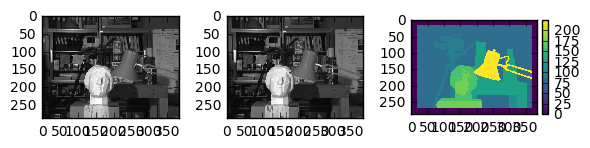

Image resolution: (288, 384)
Max disparity: 224


In [3]:
# Read left and right images as well as ground truth
img_left = skio.imread("tsuk_L.png", as_grey=True)
img_right = skio.imread("tsuk_R.png", as_grey=True)
ground_truth = load_ground_truth("tsuk_gt.pgm")
print(ground_truth.shape)
ground_truth[ground_truth == np.inf] = 0

# since the images are too large (1980 x 2880) rescale them to 198 x 288
# NOTE: rescale the disparity too!
scale_down_factor = 1.0
if scale_down_factor != 1.0:
    from skimage.transform import rescale, resize
    img_left = rescale(img_left, 1.0/scale_down_factor, preserve_range=True)
    img_right = rescale(img_right, 1.0/scale_down_factor, preserve_range=True)
    ground_truth = rescale(ground_truth, 1.0/scale_down_factor, preserve_range=True)/scale_down_factor

ground_truth = ground_truth.astype('int16')

skio.imshow_collection([img_left, img_right, ground_truth])
plt.show()
print("Image resolution: {}".format(img_left.shape))
max_disp = np.max(ground_truth)
print("Max disparity: {}".format(max_disp))

LBP loop took 0.13253715833s on average


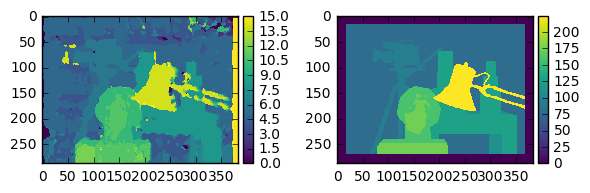

In [4]:
# Initialise a MRF and calculate the some (possible sub-optimal) disparity assignemnt
img_res = img_left.shape
mrf = StereoMRF(img_res, n_levels=16)
disp_map = mrf.lbp(img_left, img_right, n_iter=30)
skio.imshow_collection([disp_map, ground_truth])
plt.show()